# Analysis Report: U.S. Economic Landscape and Investment Outlook with Exploratory Data Analysis in R

Sept 11th 2025


### Overview:
The United States of America is the world’s largest economic powerhouse and holds the authority to change the global economic scene in an instant. For investors, many are not certain about the state that America is in, and whether or not it is an opportune moment to invest. Of which, concerns over three key issues: the impact of U.S. tariffs, risks associated with high national debt, and the potential for the dollar to be replaced by other currencies are to be discussed. This report strives to bring analysis based on factual data in R and ongoing policies to give investors insights into the American market. The report argues that despite current uncertainties, the United States remains a compelling market for investment, offering opportunities in hedging market volatility, capitalizing on policy-supported emerging industries, and leveraging trends in domestic industry reshoring.



We first begin setup by importing our libraries.

In [45]:
library(ggplot2)
library(dplyr)
library(tidyverse)
library(scales) # For better formatting
library(purrr) # Vector work
library(tidyquant)
library(tseries)
library(rugarch)

#### Overview: The Current Stock Market

To get an understanding of the current stock market, let us monitor its trends for the past few years. 
We can first monitor the moving average of the S&P 500 and notice that during Trump's presidency, the stock index has steadily climbed (as of Sept 1 2025). After a so-called "liberation day", the market plunged but soon recovered. 

Warning message:
"Removed 248 rows containing missing values or values outside the scale range
(`geom_line()`)."


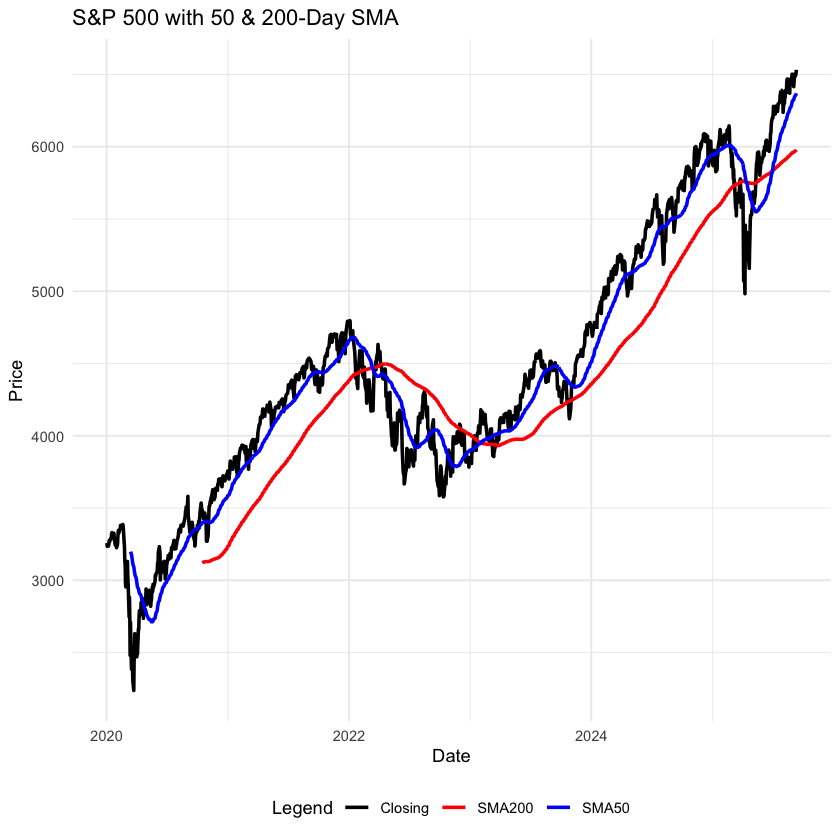

In [46]:

GSPC <- getSymbols("^GSPC", src = "yahoo", from = "2020-01-01", to = Sys.Date(), auto.assign = FALSE)

# Calculate moving averages
sma50 <- SMA(Cl(GSPC), n = 50)
sma200 <- SMA(Cl(GSPC), n = 200)

# data frame for ggplot
df <- data.frame(
  Date = index(GSPC),
  Closing = as.numeric(Cl(GSPC)),
  SMA50 = as.numeric(sma50),
  SMA200 = as.numeric(sma200)
)

# Convert to long format for ggplot
df_long <- df %>%
  pivot_longer(cols = c("Closing", "SMA50", "SMA200"),
               names_to = "Type",
               values_to = "Price")

# Plot using ggplot
ggplot(df_long, aes(x = Date, y = Price, color = Type)) +
  geom_line(size = 1) +
  scale_color_manual(values = c("Closing" = "black", "SMA50" = "blue", "SMA200" = "red")) +
  labs(title = "S&P 500 with 50 & 200-Day SMA",
       x = "Date",
       y = "Price",
       color = "Legend") +
  theme_minimal() +
  theme(legend.position = "bottom")

Taking a look at a simple moving average from 2020/01/01 to 2025/09/11, in the short term, there are risks of volatility as the trends are not completely stable nearing 2025. We observe that in the 200-day MA the price stays consistently above the MA, signalling a healthy and long-term hold. 

In the short term, however, things seem more susceptible to volatility. Policy uncertainty under the Trump administration will continue to drive market volatility. In addition, the U.S. stock market has repeatedly hit new highs since June-August, leading investors to grow increasingly cautious about mounting correction risks.


We shall do some simple analysis using a simplified GARCH model to show the volatility in the next few days:

The GARCH(1,1) model suggests that the volatility today is affected by the value yesterday and the volatility yesterday, given the time-series data. 


$\text{Given the mean equation: } r_t = \mu + a_t, 
\text{ noise equation: } a_t = \varepsilon_t \sigma_t, \hspace{0.1cm}\epsilon_t \sim N(0,1) \text{ and variance equation: }\sigma_t^2 = \omega + \alpha a_{t-1}+\beta\sigma_{t-1}^2 \\$

$$\text{Where, }  a_{t-1} \text{ is the impact of yesterday's price and } \sigma_{t-1}^2 \text{ is the impact of yesterday's volatility } \\
\omega, \alpha, \beta \in  \mathbb{R}$$

In [47]:
# Fitting model 
getSymbols("^GSPC", src = "yahoo", from = "2020-01-01")
sp500 <- Cl(GSPC) # getting the closing prices
returns <- diff(log(sp500))[-1] # log returns for better statistical properties

spec <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1,1)),
  mean.model = list(armaOrder = c(0,0)), 
  distribution.model = "norm"
)

fit <- ugarchfit(spec = spec, data = returns)
# show(fit)

[1] "GSPC"

      2025-09-10
T+1  0.006615514
T+2  0.006880581
T+3  0.007127906
T+4  0.007359521
T+5  0.007577092
T+6  0.007782012
T+7  0.007975458
T+8  0.008158438
T+9  0.008331823
T+10 0.008496374


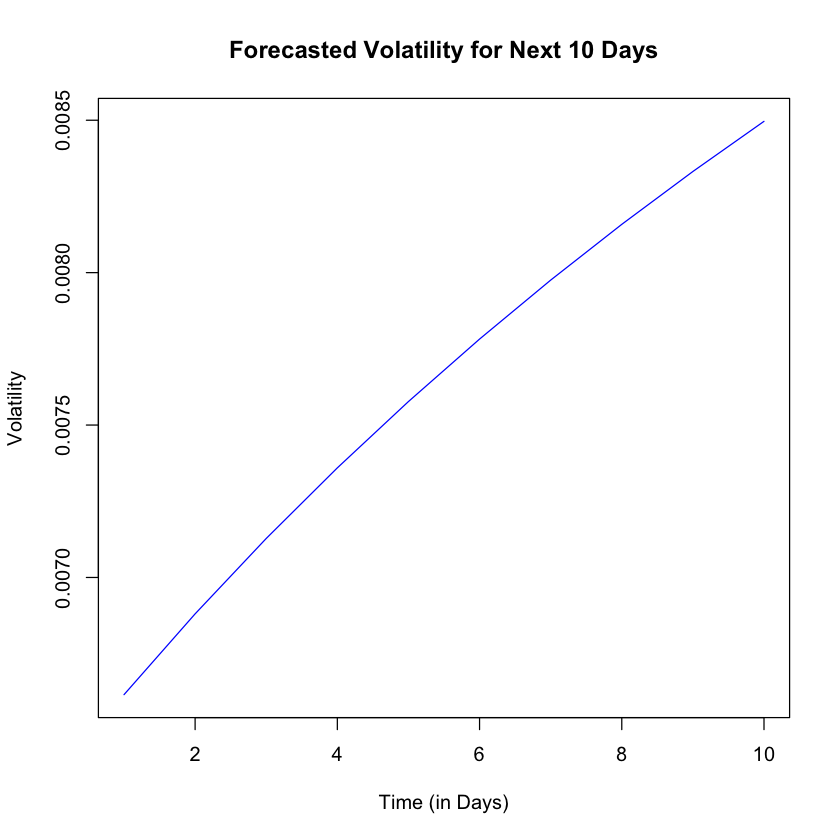

In [48]:
# Make predictions for the next 10 days
forecast_vol <- ugarchforecast(fit, n.ahead = 10)
sigma_forecast <- sigma(forecast_vol)
print(sigma_forecast)

plot(sigma_forecast, type = "l", 
    main = "Forecasted Volatility for Next 10 Days", 
    xlab = "Time (in Days)", 
    ylab = "Volatility", 
    col = "blue")


Effectively, the model shows us that for the next 10 days, the forecasted volatility of the prices will increase day by day. 
Meaning, for $68$% of daily returns are expected to fall within the $\pm 0.65$% of the mean return. We know that this would near  $68$% as we assumed that: $\epsilon_t \sim N(0,1) \\$ as it lies one $\sigma$ away.

### Section 1.1: Manufacturing

In 2000, the global share of manufacturing output was the United States at 26.5%, Japan at 18.1%, Germany at 7.0%, and China at 6.9%. In 2024, the four countries still hold around 60% of the world’s manufacturing outputs, with the shares being: China increased to 31.6%, United States down to 15.9%, Japan at 6.5% and Germany at 4.8%. 

China's industrial expansion over this period was largely fueled by absorbing shares from the other three industrial powers (U.S., Japan, Germany). Simultaneously, China continuously upgraded its industrial structure and exported labor-intensive, low-to-mid-tier production to other regions (e.g., Southeast Asia).



### Section 1.2: Trade Deficit
Prior to the 2017 U.S.-China trade war, half of the deficit originated from China. By 2024, China’s share had declined to 25%, meaning that 75% of the shares are distributed by the rest of the world. This is a part of the reason why the Trump administration imposed tariffs on every country in the world and not exclusively on China. 

There are two perspectives on the trade deficit that the U.S. is enduring. Positively, this deficit corresponds to sustained global demand for dollar-denominated assets like Treasury bonds, granting the U.S. Treasury greater flexibility in debt issuance and the Federal Reserve more room to manage interest rate policy. However, high interest rates have sharply increased debt servicing costs, while potential constraints on Treasury issuance could undermine long-term confidence in the dollar.

In [49]:
trade_df <- read.csv("datasets/BOPGSTB.csv")
trade_df$observation_date <- as.Date(trade_df$observation_date)
filter_trade <- filter(trade_df, observation_date >= "2010-01-01" )
filter_trade$BOPGSTB <- filter_trade$BOPGSTB / 1000 # Converted to billions
tail(filter_trade)


,observation_date,BOPGSTB
,<date>,<dbl>
182,2025-02-01,-120.278
183,2025-03-01,-136.419
184,2025-04-01,-60.191
185,2025-05-01,-71.116
186,2025-06-01,-59.086
187,2025-07-01,-78.311


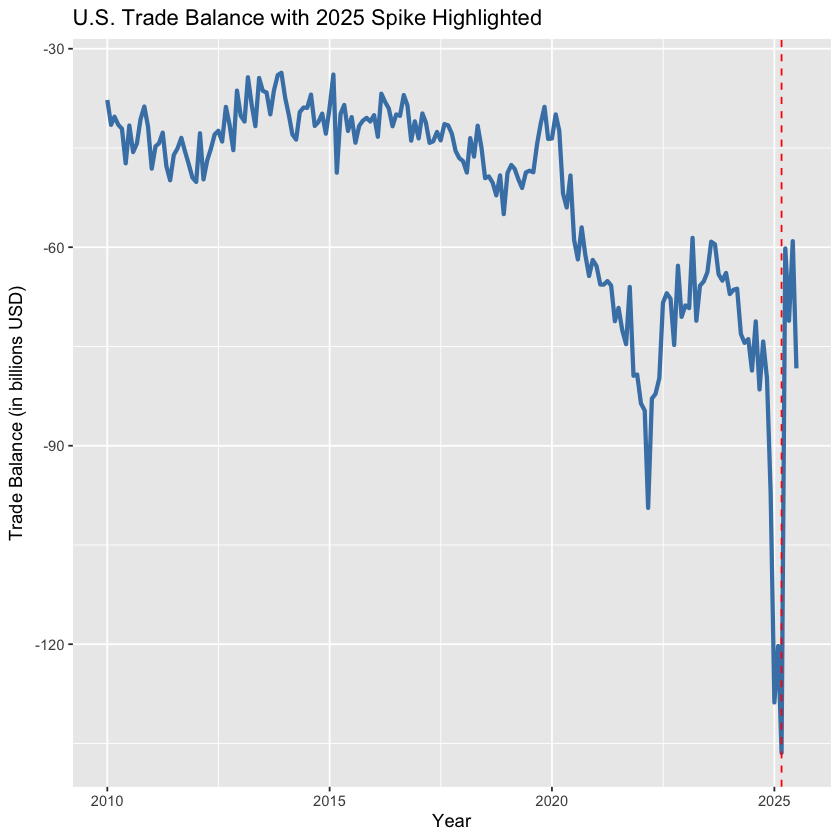

In [50]:
spike_date <- filter_trade$observation_date[which.min(filter_trade$BOPGSTB)]

plot <- filter_trade |>
  ggplot(aes(x = observation_date, y = BOPGSTB)) +
  geom_line(linewidth = 1.2, color = "steelblue") +
  geom_vline(xintercept = spike_date, 
             color = "red", 
             linetype = "dashed", 
             linewidth = 0.5) +
  labs(title = "U.S. Trade Balance with 2025 Spike Highlighted",
       x = "Year",
       y = "Trade Balance (in billions USD)") 

print(plot)

In [51]:
lowest_point <- filter_trade[which.min(filter_trade$BOPGSTB), ]
print(lowest_point)


    observation_date  BOPGSTB
183       2025-03-01 -136.419


We can see from the graph shown above that the U.S. was at an all time high for deficits in early 2025. Well exceeding 130 billion US dollars. This is likely caused by the increase in imports of goods and materials due to tariffs. However, we shall observe that the sharp decline in the deficit has reverted. This, is due to a dramatic drop in consumer goods imports, especially the trade gap with China. The trade gap with China has shrank to its lowest in 21 years according to CNBC reports. 

### Section 1.4: Share of Global GDP

In 2000, the United States accounted for 30.3% of global GDP, followed by the EU and UK at 26.2%, Japan at 14.6%, and China at 3.5%. By 2024, these shares had shifted significantly: the U.S. represented 26.3%, the EU and UK 20.5%, China 16.9%, and Japan 3.8%.
Japan’s nominal GDP reached its closest point to the U.S. in 1995, when it was approximately 73% of the U.S. economy. Similarly, China’s GDP peaked relative to the U.S. in 2021, reaching about 75% of the U.S. size. However, by 2024, China’s nominal GDP had declined to roughly 65% of the U.S. level, due to an 11-12% depreciation of the Chinese yuan against the U.S. dollar since 2021.
	While the United States wishes to weaken the U.S. dollar to boost export competitiveness, it must avoid excessive depreciation that could undermine the currency’s global utility or severely erode its purchasing power. Moreover, there is a strategic concern that an overly depreciated dollar could accelerate China’s economy, potentially overtaking the U.S. on the global stage.


### Section 1.5: Money Supply 

Since 2000, the U.S. M2 money supply grew approximately fourfold by early 2025, reaching $21.7 trillion. While China’s M2 money supply was 13.6 trillion yuan in 2000 and expanded nearly twentyfold by the end of 2024, reaching 307 trillion yuan (equivalent to roughly 53.5 trillion USD) . However, no direct comparison can be made as differences in how M2 is defined and in the structure of their financial systems mean these figures are not directly comparable. The U.S. is primarily direct finance-based, meaning a significant portion of assets resides in securities markets rather than bank deposits, thus not fully captured in M2. In contrast, China’s currency is backed by substantial foreign exchange reserves and gold, and its financial system remains bank-dominated and indirect finance-oriented. 


In [52]:
chinaM2 <- read.csv("datasets/chinaM2.csv")
usM2 <- read.csv("datasets/usM2.csv")

usM2 <- usM2 |>
    rename(Dollars = MYAGM2USM052S, Date = observation_date)

chinaM2 <- chinaM2 |>
    rename(Dollars = MYAGM2CNM189N, Date = observation_date)

# Convert DATE columns to actual date format
usM2$Date <- as.Date(usM2$Date)
chinaM2$Date <- as.Date(chinaM2$Date)

usM2_filter <- filter(usM2, Date >= "1998-12-01")

head(usM2_filter)


,Date,Dollars
,<date>,<dbl>
1,1998-12-01,4.3734e+12
2,1999-01-01,4.3943e+12
3,1999-02-01,4.4209e+12
4,1999-03-01,4.4321e+12
5,1999-04-01,4.4598e+12
6,1999-05-01,4.4782e+12


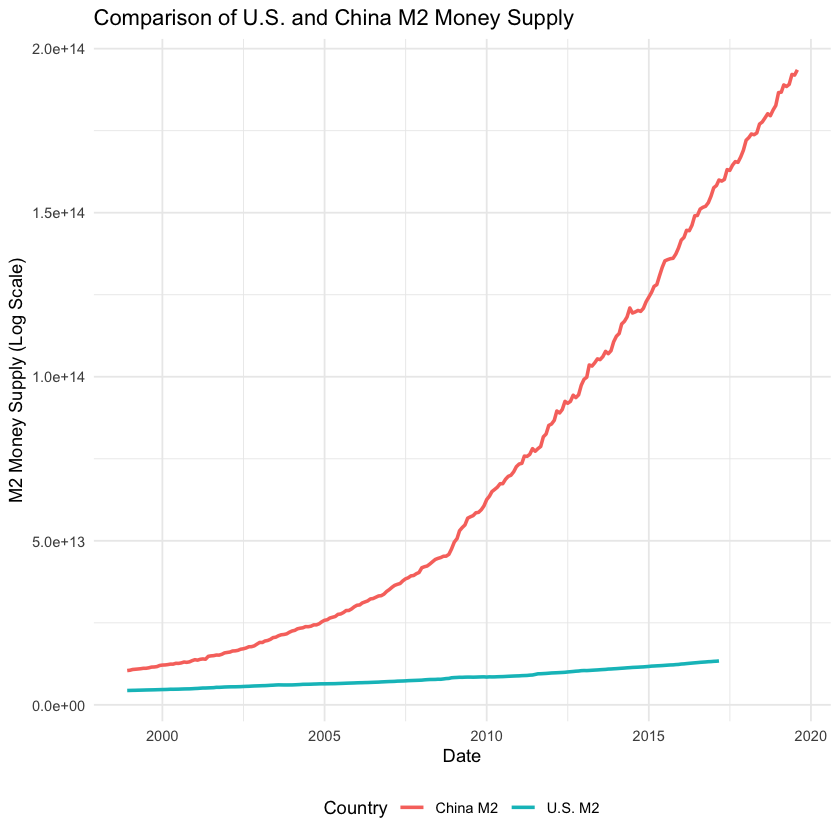

In [53]:

combined_plot <- ggplot() +
  geom_line(data = usM2_filter, aes(x = Date, y = Dollars, color = "U.S. M2"), linewidth = 1) +
  geom_line(data = chinaM2, aes(x = Date, y = Dollars, color = "China M2"), linewidth = 1) +
  labs(title = "Comparison of U.S. and China M2 Money Supply",
       x = "Date",
       y = "M2 Money Supply (Log Scale)",
       color = "Country") +
  theme_minimal() +
  theme(legend.position = "bottom")

print(combined_plot)

## SECTION 2, Trump’s Policies and the Line of Logic
Throughout his campaign, Trump consistently reiterated his goals to create high-wage jobs for Americans while addressing the nation’s high debt burden. Many of Trump’s policies revolve around his plans for economic reform in America. 

The line of logic and main goals flows as follows:
Bring industries back to the U.S. for reindustrialization → Create jobs and reduce the trade deficit → Increase tax revenue, shrink the deficit, and reduce national debt. 

Following this underlying logic, many of his actions and headlines revolved around this core theme:

- Cracking down on illegal immigration to reduce labor supply competition and raise wages for Americans. 
- Imposing tariffs to force industry reshoring 
- Choosing the Middle East for his first official visit to ensure international energy prices and U.S. interests.
- Linking trade negotiations to domestic investment commitments
- Cutting bureaucratic waste and reducing public spending.

The Trump administration recognizes that the global economic system has developed a “path dependency” over the past three decades. By leveraging executive authority, the administration is pursuing a strategy of strategic rule-shifting to implement policies designed to recalibrate global economic architectures in favor of U.S. interests. 
This approach mirrors historic moments of the dissolution of the Bretton Woods system in the 1970s, wherein Washington redefined global rules without diminishing the dollar’s centrality, thus ensuring that structural reforms advance national objectives while maintaining international confidence in U.S. leadership.


### Section 2.1: Trump’s First and Current Presidential Term

The first Trump administration pursued an agenda defined by economic nationalism, unilateral policy actions, and deregulation, resulting in several significant outcomes. Trump redefined international relations by signing trade deals and opting out of agreements. 

As part of the USMCA trade agreement negotiated with Canada and Mexico, the Trump administration secured a key provision requiring that 75% of automotive manufacturing content originate within the U.S. This measure reinforced American leverage in regional trade, with both Canada and Mexico promptly agreeing to the terms. 

The Trump administration has pursued an unconventional agenda characterized by rapid execution as seen when the U.S. withdrew from the Trans-Pacific Partnership, the Paris Climate Agreement, and the Iran Nuclear Deal, while pressuring NATO allies to increase defense spending. Most notably, using tariffs as leverage, Trump forced China back to negotiations and secured the Phase One agreement. Overall, economic and market indicators showed significant upward momentum during this period in time. 
